# Data Cleaning Checklist

## Before Train/Test Split
- Remove irrelevant columns  
- Remove duplicates  
- Drop constant-value columns  
- Standardize column names  
- Fix data types  
- Explore missing values  
- Explore outliers  
- Create derived features  

## After Train/Test Split
- Impute missing values (fit on train, apply to test)  
- Encode categorical variables (fit on train, apply to test)  
- Scale/normalize numeric features (fit on train, apply to test)  
- Handle outliers (fit thresholds on train, apply to test)  
- Feature selection (train only, apply same to test)  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Step 11 — Notebook Setup & Objectives
Briefly state the goal of this notebook: cleaning and preparing data for modeling.  
Clarify this is **not modeling**, only transformations.

In [2]:
# Drop PassengerId, Name, Ticket → identifiers/free-text with no predictive value.  
# Handle missing values:  
    # Age (177 missing) → impute (median or model-based).  
    # Cabin (687 missing) → drop or create CabinKnown flag.  
    # Embarked (2 missing) → fill with mode.  
# Encode categorical features:  
    # Sex → binary encode (0 = male, 1 = female).  
    # Pclass → treat as ordinal or one-hot encode.  
    # Embarked → one-hot encode (C, Q, S).  
# Feature engineering:  
    # FamilySize = SibSp + Parch + 1.  
    # IsAlone = (FamilySize == 1).  
    # CabinKnown = (Cabin not null).  
    # Fare_log = log1p(Fare) (optional to reduce skew).  
# Combine SibSp + Parch into FamilySize:  
    # Why? Individually noisy → combined feature captures family context, shown in EDA to correlate with survival.  

#### Step 12 — Load Raw Data (read-only)
- Load the dataset(s) from `../data/raw/`.  
- Keep original files unchanged — all transformations happen in this notebook.

In [3]:
titanic = pd.read_csv('../data/raw/train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Step 13 — Check for Duplicates
- Check for **fully duplicated rows**.  
- Check for **duplicate IDs** if an ID column exists.  
- Decide whether to drop duplicates or keep them based on domain logic.  
  (e.g., keep if duplicates are valid transactions, drop if accidental repeats).

In [4]:
titanic[titanic.duplicated()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


#### Step 14 — Clean Column & Index Names
- Standardize column names (e.g., lowercase, replace spaces with `_`).  
- Remove leading/trailing whitespace.  
- Optionally, rename columns for clarity (domain-specific).  
- Ensure row indices are unique and reset if necessary.  

In [5]:
titanic.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
756,757,0,3,"Carlsson, Mr. August Sigfrid",male,28.0,0,0,350042,7.7958,NaN,S
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C
873,874,0,3,"Vander Cruyssen, Mr. Victor",male,47.0,0,0,345765,9.0000,NaN,S


In [6]:
titanic.columns = (titanic.columns.str.strip().str.lower().str.replace(" ", "_"))
titanic.sample(3)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
844,845,0,3,"Culumovic, Mr. Jeso",male,17.0,0,0,315090,8.6625,NaN,S
57,58,0,3,"Novel, Mr. Mansouer",male,28.5,0,0,2697,7.2292,NaN,C
45,46,0,3,"Rogers, Mr. William John",male,NaN,0,0,S.C./A.4. 23567,8.0500,NaN,S


#### Step 15 — Define & Refine Columns
- Identify the **target variable** (the one you want to predict).  
- Identify **ID columns** (usually drop from features, unless needed for merging).  
- List **feature columns** (categorical, numeric, text, datetime, etc.).  
- Drop **irrelevant or redundant columns** (e.g., free-text IDs, names, high-cardinality noise).  
- Optionally drop columns with excessive missing values if not worth imputing.  
- Document all decisions for reproducibility.  


In [7]:
# Target Column → Survived
# ID Columns → PassengerId 
# Numerical Feature Columns → Age, Fare  
# Categorical Feature Columns → Pclass, Sex, SibSp, Parch, Cabin, Embarked
# Text/Unstructured Columns (usually dropped) → Name, Ticket


In [8]:
titanic.drop(['passengerid', 'name', 'ticket'], axis=1, inplace=True)

In [9]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


#### Step 16 — Fix Data Types
- Ensure numeric features are numeric (`int`, `float`).  
- Ensure categorical features are `category` or `object`.  
- Convert date/time columns to `datetime`. 

In [10]:
titanic.sample(2)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked
94,0,3,male,59.0,0,0,7.25,NaN,S
560,0,3,male,NaN,0,0,7.75,NaN,Q


In [11]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       714 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   cabin     204 non-null    object 
 8   embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


#### Step 17 — Minimal Feature Engineering (pre-split)
- Create simple derived features that don’t depend on imputation.   
- Avoid imputing or scaling here (leave for post-split).  

In [12]:
# --- Minimal Feature Engineering (pre-split) ---
# Create family-related features because family presence may influence survival.
#  - family_size = sibsp + parch + 1
#    (captures total number of family members aboard, including self)
#  - is_alone = 1 if family_size == 1 else 0
#    (captures isolation, which may impact behavior/help likelihood)

# Create cabin indicator because cabin information itself is too granular,
# but knowing whether a passenger had a recorded cabin can add signal.
#  - cabin_known = 1 if Cabin is not null else 0
#    (missing cabin data often indicates lower-class passengers, which is predictive) 

In [13]:
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

In [14]:
titanic.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,family_size
270,0,1,male,NaN,0,0,31.000,NaN,S,1
816,0,3,female,23.0,0,0,7.925,NaN,S,1
245,0,1,male,44.0,2,0,90.000,C78,Q,3
145,0,2,male,19.0,1,1,36.750,NaN,S,3
536,0,1,male,45.0,0,0,26.550,B38,S,1


In [15]:
titanic['is_alone'] = (titanic['family_size'] == 1).astype(int)

In [16]:
titanic.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,family_size,is_alone
120,0,2,male,21.0,2,0,73.5000,NaN,S,3,0
359,1,3,female,NaN,0,0,7.8792,NaN,Q,1,1
158,0,3,male,NaN,0,0,8.6625,NaN,S,1,1
321,0,3,male,27.0,0,0,7.8958,NaN,S,1,1
30,0,1,male,40.0,0,0,27.7208,NaN,C,1,1


In [17]:
# categorical features

titanic.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
cabin          687
embarked         2
family_size      0
is_alone         0
dtype: int64

In [18]:
titanic['cabin'].isna().sum()

np.int64(687)

In [19]:
# Cabin_known

titanic['cabin_known'] = titanic['cabin'].isna().astype(int)
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,family_size,is_alone,cabin_known
0,0,3,male,22.0,1,0,7.2500,NaN,S,2,0,1
1,1,1,female,38.0,1,0,71.2833,C85,C,2,0,0
2,1,3,female,26.0,0,0,7.9250,NaN,S,1,1,1
3,1,1,female,35.0,1,0,53.1000,C123,S,2,0,0
4,0,3,male,35.0,0,0,8.0500,NaN,S,1,1,1


In [20]:
titanic = titanic.drop(columns=['sibsp', 'parch', 'cabin'])

In [21]:
titanic.head()

,survived,pclass,sex,age,fare,embarked,family_size,is_alone,cabin_known
0,0,3,male,22.0,7.2500,S,2,0,1
1,1,1,female,38.0,71.2833,C,2,0,0
2,1,3,female,26.0,7.9250,S,1,1,1
3,1,1,female,35.0,53.1000,S,2,0,0
4,0,3,male,35.0,8.0500,S,1,1,1


#### Step 18 — Handle Missing Values (post-split)
- **Numeric features**: median, mean, or group-based median.  
- **Categorical features**: mode or new category (`"Unknown"`).  
- **High missingness (>40–50%)**: consider dropping column.  
- Document chosen method.  
*(Fit on training data only, then apply to test.)*

In [22]:
titanic.select_dtypes(include=['number']).isna().sum()

survived         0
pclass           0
age            177
fare             0
family_size      0
is_alone         0
cabin_known      0
dtype: int64

In [23]:
# only Numerical feature with 177 missing value is age.
# checking the rate of the missing value

age_missing_rate = round(titanic['age'].isna().sum() / len(titanic) * 100, 2)
age_missing_rate

np.float64(19.87)

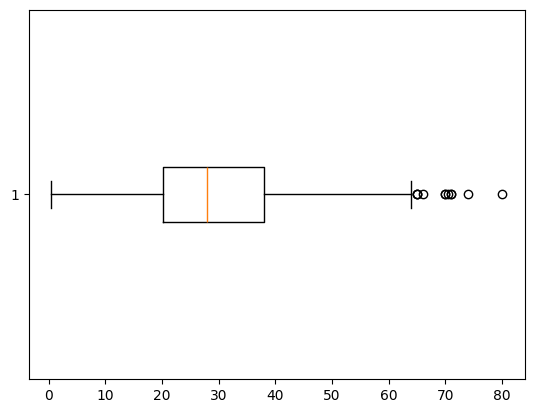

In [24]:
fig, ax = plt.subplots()
ax.boxplot(titanic['age'].dropna(), vert=False)
plt.show()

In [25]:
# Boxplot (Age) → The median age ~29. Most values fall between 22–36 (IQR). A few outliers exist at higher ages (~65–80).

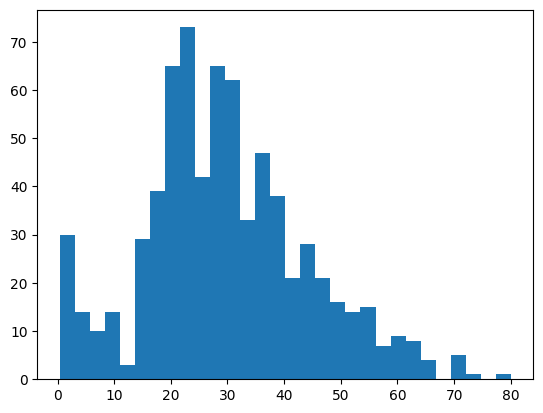

In [26]:
fig, ax = plt.subplots()
ax.hist(titanic['age'].dropna(), bins=30)
plt.show()

In [27]:
# Histogram (Age) → The distribution is right-skewed, with most passengers between 20–40 years, a smaller number of children, and fewer older passengers.
# Conclusion: Age is centered in young adults, with some children and elderly as outliers. Median/mean imputation is reasonable.

In [28]:
# Options:

# Mean
    # Sensitive to outliers.
    # Since Age distribution is right-skewed (a long tail of older passengers), the mean will be pulled upward.
    # Filling missing values with the mean (~29–30) would overestimate ages for younger passengers.

# Median
    # Robust to skew and outliers.
    # Since Age is skewed, median is the safer imputation.
    # It better represents the “typical” passenger.
    
# but group-based (e.g., by Pclass or Sex) might better capture patterns.

In [29]:
# General rule for future observations

# When comparing group means/medians:
# Small differences (e.g., <5%) → likely weak/no relationship.
# Moderate differences (10–20%) → possible relationship, worth checking further.
# Large differences (20%+) → strong relationship, probably useful for modeling or imputation.

In [30]:
titanic.head()

,survived,pclass,sex,age,fare,embarked,family_size,is_alone,cabin_known
0,0,3,male,22.0,7.2500,S,2,0,1
1,1,1,female,38.0,71.2833,C,2,0,0
2,1,3,female,26.0,7.9250,S,1,1,1
3,1,1,female,35.0,53.1000,S,2,0,0
4,0,3,male,35.0,8.0500,S,1,1,1


In [31]:
sex_age_mean = titanic.groupby('sex')['age'].mean()
sex_age_mean

sex
female    27.915709
male      30.726645
Name: age, dtype: float64

In [32]:
sex_age_median = titanic.groupby('sex')['age'].median()
sex_age_median

sex
female    27.0
male      29.0
Name: age, dtype: float64

In [33]:
# checking the mean rates

sex_age_mean_rate = round(((sex_age_mean.max() - sex_age_mean.min()) / sex_age_mean.min()) * 100, 2)
sex_age_mean_rate

np.float64(10.07)

In [34]:
# checking the median rates

sex_age_median_rate = round(((sex_age_median.max() - sex_age_median.min()) / sex_age_median.min()) * 100, 2)
sex_age_median_rate

np.float64(7.41)

In [35]:
# Mean = ~11% → mild/moderate
# Median = ~7% → mild

# So overall: Sex vs Age shows only a weak-to-moderate relationship (not very strong, but not zero either).

# Males are on average slightly older than females. The difference is consistent in both mean and median. 
# This suggests that imputing missing Age with a sex-specific value (27 for females, 29 for males) would better respect the distribution than a global fill.

In [36]:
pclass_age_mean = titanic.groupby('pclass')['age'].mean()
pclass_age_mean

pclass
1    38.233441
2    29.877630
3    25.140620
Name: age, dtype: float64

In [37]:
pclass_age_median = titanic.groupby('pclass')['age'].median()
pclass_age_median

pclass
1    37.0
2    29.0
3    24.0
Name: age, dtype: float64

In [38]:
pclass_age_mean_rate = round(((pclass_age_mean.max() - pclass_age_mean.min()) / pclass_age_mean.min()) * 100, 2)
pclass_age_mean_rate

np.float64(52.08)

In [39]:
pclass_age_median_rate = round(((pclass_age_median.max() - pclass_age_median.min()) / pclass_age_median.min()) * 100, 2)
pclass_age_median_rate

np.float64(54.17)

In [40]:
# Mean = ~52% → strong
# Median = ~54% → strong

# So overall: Pclass vs Age shows a strong relationship.  
# Higher-class passengers were significantly older on average than lower-class passengers.  
# The difference is consistent in both mean and median (over 50%).  
# This suggests that imputing missing Age values using Pclass-specific medians (e.g., 37 for 1st, 29 for 2nd, 24 for 3rd)  
# will preserve the strong social stratification pattern in the data.

In [41]:
# Conclusion:
# Both Sex and Pclass show a meaningful relationship with Age. 
# Pclass has a stronger influence (clear age gaps between 1st, 2nd, and 3rd class), 
# while Sex also shows differences in age distribution. 
# To preserve both social and demographic patterns in the data, 
# we will impute missing Age values using the combination of Pclass and Sex groups.

In [42]:
# We should use the median group-based imputation (Pclass + Sex).

# Reason:
# Age is right-skewed → mean is distorted.
# Grouping already preserves social patterns (class + gender).
# Median within each group gives the most stable/robust “typical age” for that subgroup.

In [43]:
# Fit on training data only, then apply to test.

In [44]:
from sklearn.model_selection import train_test_split

X = titanic.drop(['survived'], axis=1)
y = titanic['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [45]:
# We use stratify=y because this is a classification problem.
# Stratification ensures the train and test sets keep the same class balance as the full dataset.
# Without it, the split might create skewed subsets (e.g., too many survivors in train, too few in test),
# which would bias model evaluation. This is best practice for categorical targets.

In [46]:
# First, create a lookup table of median ages for each (sex, pclass) group.
# This is needed because imputation is group-based, not global.
# For TRAIN we can directly use transform('median'), but for TEST we must
# reuse the TRAIN medians (to avoid data leakage).
# (If we were filling with a single global median, no lookup table would be needed.)

In [47]:
med_tbl = (
    X_train.groupby(['sex', 'pclass'])['age']
    .median()
    .rename('age_median')
    .reset_index()
)
med_tbl

,sex,pclass,age_median
0,female,1,35.0
1,female,2,29.0
2,female,3,21.5
3,male,1,40.0
4,male,2,30.0
5,male,3,26.0


In [48]:
X_train['age'] = X_train['age'].fillna(X_train.groupby(['sex', 'pclass'])['age'].transform('median'))
X_train.isna().sum()

pclass         0
sex            0
age            0
fare           0
embarked       2
family_size    0
is_alone       0
cabin_known    0
dtype: int64

In [49]:
X_test.head()

,pclass,sex,age,fare,embarked,family_size,is_alone,cabin_known
565,3,male,24.0,24.1500,S,3,0,1
160,3,male,44.0,16.1000,S,2,0,1
553,3,male,22.0,7.2250,C,1,1,1
860,3,male,41.0,14.1083,S,3,0,1
241,3,female,NaN,15.5000,Q,2,0,1


In [50]:
# --- Impute missing 'age' in X_test using TRAIN medians ---

# Merge test data with the lookup table (med_tbl) built from X_train
X_test = X_test.merge(med_tbl, on=['sex', 'pclass'], how='left')

In [51]:
X_test

,pclass,sex,age,fare,embarked,family_size,is_alone,cabin_known,age_median
0,3,male,24.0,24.1500,S,3,0,1,26.0
1,3,male,44.0,16.1000,S,2,0,1,26.0
2,3,male,22.0,7.2250,C,1,1,1,26.0
3,3,male,41.0,14.1083,S,3,0,1,26.0
4,3,female,NaN,15.5000,Q,2,0,1,21.5
...,...,...,...,...,...,...,...,...,...
174,2,female,25.0,26.0000,S,2,0,1,29.0
175,3,male,20.0,7.8542,S,1,1,1,26.0
176,2,male,28.0,10.5000,S,1,1,1,30.0
177,2,female,23.0,13.7917,C,1,1,0,29.0


In [52]:
X_test.isna().sum()

pclass          0
sex             0
age            40
fare            0
embarked        0
family_size     0
is_alone        0
cabin_known     0
age_median      0
dtype: int64

In [53]:
# Fill missing ages with the corresponding group median from TRAIN
X_test['age'] = X_test['age'].fillna(X_test['age_median'])

# Drop helper column
X_test = X_test.drop(columns=['age_median'])
X_test

,pclass,sex,age,fare,embarked,family_size,is_alone,cabin_known
0,3,male,24.0,24.1500,S,3,0,1
1,3,male,44.0,16.1000,S,2,0,1
2,3,male,22.0,7.2250,C,1,1,1
3,3,male,41.0,14.1083,S,3,0,1
4,3,female,21.5,15.5000,Q,2,0,1
...,...,...,...,...,...,...,...,...
174,2,female,25.0,26.0000,S,2,0,1
175,3,male,20.0,7.8542,S,1,1,1
176,2,male,28.0,10.5000,S,1,1,1
177,2,female,23.0,13.7917,C,1,1,0


In [54]:
X_test.isna().sum()

pclass         0
sex            0
age            0
fare           0
embarked       0
family_size    0
is_alone       0
cabin_known    0
dtype: int64

In [55]:
# END OF FILLING THE MISSING NUMERICAL FEATUER

In [56]:
# Filling Categorical Feature 'embarked'

In [57]:
embarked_missing_rate = round(X_train['embarked'].isna().sum() / len(X_train) * 100, 2)
embarked_missing_rate

np.float64(0.28)

In [58]:
# Decide whether to drop the rows

# Missing rows = 2.
# If we drop them, we lose 0.2% of data → negligible.
# If we keep them, we must impute.
# Both are acceptable, but dropping is fine when very few rows are missing. If it were 50+ rows missing, we’d impute instead.

In [59]:
# If imputing → check distribution
X_train['embarked'].value_counts(normalize=True) * 100

embarked
S    72.676056
C    19.577465
Q     7.746479
Name: proportion, dtype: float64

In [60]:
# If imputing, the usual strategy is to fill missing with the mode (most frequent, "S"). This preserves distribution.
# Fill with mode ("S") → if we don’t want to lose any rows.

In [61]:
X_train = X_train.dropna(subset=['embarked'])

In [62]:
X_train.isna().sum()

pclass         0
sex            0
age            0
fare           0
embarked       0
family_size    0
is_alone       0
cabin_known    0
dtype: int64

#### Step 19 — Categorical Encoding
- **Binary categories** → map to 0/1.  
- **Multi-class categories** → one-hot encoding or target encoding.  
- **Ordinal categories** → map to ordered integers.  
*(Fit encoders on training data only, then apply to test.)*

In [63]:
X_train.head()

,pclass,sex,age,fare,embarked,family_size,is_alone,cabin_known
692,3,male,26.0,56.4958,S,1,1,1
481,2,male,30.0,0.0000,S,1,1,1
527,1,male,40.0,221.7792,S,1,1,0
855,3,female,18.0,9.3500,S,2,0,1
801,2,female,31.0,26.2500,S,3,0,1


In [64]:
X_train.nunique()

pclass           3
sex              2
age             85
fare           225
embarked         3
family_size      9
is_alone         2
cabin_known      2
dtype: int64

In [65]:
# Binary encoding for 'sex' X_train
X_train['sex'] = X_train['sex'].map({'male': 0, 'female': 1})

In [66]:
X_train.head()

,pclass,sex,age,fare,embarked,family_size,is_alone,cabin_known
692,3,0,26.0,56.4958,S,1,1,1
481,2,0,30.0,0.0000,S,1,1,1
527,1,0,40.0,221.7792,S,1,1,0
855,3,1,18.0,9.3500,S,2,0,1
801,2,1,31.0,26.2500,S,3,0,1


In [67]:
# Binary encoding for 'sex' X_test
X_test['sex'] = X_test['sex'].map({'male': 0, 'female': 1})

In [68]:
X_test.head()

,pclass,sex,age,fare,embarked,family_size,is_alone,cabin_known
0,3,0,24.0,24.1500,S,3,0,1
1,3,0,44.0,16.1000,S,2,0,1
2,3,0,22.0,7.2250,C,1,1,1
3,3,0,41.0,14.1083,S,3,0,1
4,3,1,21.5,15.5000,Q,2,0,1


In [69]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [70]:
# Fit on TRAIN only
ohe.fit(X_train[['embarked']])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [71]:
X_train_embarked_ohe = ohe.transform(X_train[['embarked']])
X_test_embarked_ohe = ohe.transform(X_test[['embarked']])

In [72]:
# Convert to DataFrames with proper column names
train_embarked_df = pd.DataFrame(X_train_embarked_ohe, 
    columns=ohe.get_feature_names_out(['embarked']),
    index=X_train.index)

In [73]:
train_embarked_df

,embarked_C,embarked_Q,embarked_S
692,0.0,0.0,1.0
481,0.0,0.0,1.0
527,0.0,0.0,1.0
855,0.0,0.0,1.0
801,0.0,0.0,1.0
...,...,...,...
359,0.0,1.0,0.0
258,1.0,0.0,0.0
736,0.0,0.0,1.0
462,0.0,0.0,1.0


In [74]:
test_embarked_df = pd.DataFrame(X_test_embarked_ohe, 
    columns=ohe.get_feature_names_out(['embarked']),
    index=X_test.index)

In [75]:
test_embarked_df

,embarked_C,embarked_Q,embarked_S
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0
...,...,...,...
174,0.0,0.0,1.0
175,0.0,0.0,1.0
176,0.0,0.0,1.0
177,1.0,0.0,0.0


In [76]:
X_train = pd.concat([X_train.drop(['embarked'], axis=1), train_embarked_df], axis=1)
X_test = pd.concat([X_test.drop(['embarked'], axis=1), test_embarked_df], axis=1)

In [77]:
X_test

,pclass,sex,age,fare,family_size,is_alone,cabin_known,embarked_C,embarked_Q,embarked_S
0,3,0,24.0,24.1500,3,0,1,0.0,0.0,1.0
1,3,0,44.0,16.1000,2,0,1,0.0,0.0,1.0
2,3,0,22.0,7.2250,1,1,1,1.0,0.0,0.0
3,3,0,41.0,14.1083,3,0,1,0.0,0.0,1.0
4,3,1,21.5,15.5000,2,0,1,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
174,2,1,25.0,26.0000,2,0,1,0.0,0.0,1.0
175,3,0,20.0,7.8542,1,1,1,0.0,0.0,1.0
176,2,0,28.0,10.5000,1,1,1,0.0,0.0,1.0
177,2,1,23.0,13.7917,1,1,0,1.0,0.0,0.0


In [78]:
X_train

,pclass,sex,age,fare,family_size,is_alone,cabin_known,embarked_C,embarked_Q,embarked_S
692,3,0,26.0,56.4958,1,1,1,0.0,0.0,1.0
481,2,0,30.0,0.0000,1,1,1,0.0,0.0,1.0
527,1,0,40.0,221.7792,1,1,0,0.0,0.0,1.0
855,3,1,18.0,9.3500,2,0,1,0.0,0.0,1.0
801,2,1,31.0,26.2500,3,0,1,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
359,3,1,21.5,7.8792,1,1,1,0.0,1.0,0.0
258,1,1,35.0,512.3292,1,1,1,1.0,0.0,0.0
736,3,1,48.0,34.3750,5,0,1,0.0,0.0,1.0
462,1,0,47.0,38.5000,1,1,0,0.0,0.0,1.0


In [79]:
Xy = X_train.copy()
Xy['survived'] = y_train
Xy.groupby('pclass')['survived'].mean()

pclass
1    0.644970
2    0.446667
3    0.242967
Name: survived, dtype: float64

In [80]:
### Encoding `pclass`

# `pclass` is an **ordinal categorical feature** (1st > 2nd > 3rd).  
# The order is meaningful: survival rates decrease monotonically from 1st to 3rd class.  

# For tree-based models, we keep `pclass` as an integer (1,2,3).  
# For linear models, we will also test a one-hot encoded version (`pclass_1`, `pclass_2`, `pclass_3`)  
# to avoid imposing a false linear relationship.  

# This approach balances efficiency with correctness and avoids information loss.


#### Step 21 — Advanced Feature Engineering
- Create ratios, interactions, or domain-based transformations.  
- Perform binning of continuous variables if appropriate.  
- Apply feature selection or dimensionality reduction (PCA, mutual info).  

In [81]:
# Skiped, data set is small and not needed

#### Step 21 — Sanity Checks After Cleaning
- Confirm no unexpected missing values remain.  
- Verify feature distributions after encoding/scaling.  
- Ensure train and test columns match.  
- Summarize all key preprocessing decisions for reproducibility.

In [82]:
# checked in step 19

In [83]:
# What to check:
#
# 1. Missing Values
#    - Run .isna().sum() on train and test.
#    - Confirm no unexpected NaN values remain.
#    - Decision: If NaNs exist, fix with imputer, drop, or domain-specific strategy.
#
# 2. Numeric Feature Distributions
#    - Use .describe(), histograms, and boxplots.
#    - Look for invalid ranges (negative ages, impossible values).
#    - Decision: If anomalies found, correct, cap, or remove them.
#
# 3. Categorical Feature Distributions
#    - Use .value_counts() on train/test categorical columns.
#    - Verify categories make sense; check for rare or unseen categories.
#    - Decision: If rare categories exist, group them; if mismatch, adjust encoding.
#
# 4. Train/Test Alignment
#    - Confirm train and test have identical columns in the same order.
#    - For encoded features, ensure one-hot variables align.
#    - Decision: If mismatch, fix preprocessing (e.g., handle_unknown="ignore").
#
# 5. Data Types
#    - Check with .dtypes.
#    - Ensure numerics are numeric, categoricals are categorical.
#    - Decision: Fix mis-typed columns if needed.

#### Step 22 — Scaling / Normalization
- Apply scaling to numeric features:  
  - `StandardScaler`, `MinMaxScaler`, or `RobustScaler`.  
- Consider log-scaling skewed features.  
*(Fit scalers on training data only, then apply to test.)*

In [84]:
# Based on scikit-learn’s estimator map, we will evaluate LinearSVC, SVC, KNN, and Ensemble classifiers.

# Scale only for LinearSVC, SVC, KNN.
# No scaling for tree ensembles.

In [85]:
X_train[['age', 'fare']].describe()

,age,fare
count,710.000000,710.000000
mean,29.331577,31.684107
std,13.244686,48.058570
min,0.420000,0.000000
25%,21.500000,7.895800
50%,26.500000,14.454200
75%,37.000000,30.695800
max,80.000000,512.329200


In [86]:
# General Rule from .describe()

# When you check .describe():
# If max is not too far from 75% → data is fairly well-behaved → StandardScaler if needed.
# If max is much larger than 75% → strong skew/outliers → log transform (then possibly scale).
# If range of one column is 10x or 100x bigger than another → consider scaling for fairness.

In [87]:
# Age

# Min: 0.42
# Max: 80
# 25%–75% (IQR): 21.5 – 37
# Mean: ~29, Std: ~13

# Interpretation:

# The range (0–80) is not extreme.
# Distribution is reasonable for human age (no crazy outliers in .describe()).
# Scaling is not strictly required unless we use distance-based models.
# StandardScaler would be a safe choice if we decide to scale.

# Decision:

# Keep as is for now.
# If model requires scaling → use StandardScaler.

In [88]:
# Fare

# Min: 0
# Max: 512
# 25%–75% (IQR): 7.9 – 30.7
# Mean: 31, Std: 48
# Notice: 75% is ~30 but max is 512 → extreme outliers + long tail.

# Interpretation:

# Distribution is very skewed.
# .describe() shows that most fares are small (<50), but a few are extremely high.
# Scaling alone won’t fix this → log transform will reduce skew, then apply scaling if needed.

# Decision:

# Apply log1p(Fare) before scaling.
# If model needs scaling → log + StandardScaler is best.
# If using tree models → you can leave Fare raw or log-transformed (trees don’t care about scale but do benefit from reducing skew).

In [89]:
# Ratio = Max / P75

# If ratio is around 2–3 → tail is modest → usually fine as-is.
# If ratio is > 5 → long tail/outliers → consider log1p (and then scale if your model needs scaling).
# If ratio is > 10 → very long tail → log1p strongly recommended.

In [90]:
# Age: Max = 80, P75 ≈ 37 → 80 / 37 ≈ 2.16
# That’s near 2 → not a long tail → no log needed.

# Fare: Max = 512, P75 ≈ 30.7 → 512 / 30.7 ≈ 16.7
# That’s >> 5 → strong right-skew → log1p helps.

In [91]:
# Why 75th percentile (and not mean/std)?
# P75 is robust to a few extreme values.
# Max vs P75 tells you how far the very top sticks out beyond what’s typical.

# What does log1p do?
# It compresses large values more than small ones.
# So those few huge fares stop dominating distance-based models (SVC/KNN) and can make tree splits more balanced too.

# One-line decisions here
# Age: no log; scale only if you use LinearSVC/SVC/KNN.
# Fare: log1p recommended; after that, scale for LinearSVC/SVC/KNN; for trees, you can use raw or log—log is often a tiny win.

In [92]:
# Log1p Decision Checklist (pro way)

# 1) Sign check
#    - If min < 0  → DO NOT use log1p. Consider Yeo–Johnson or RobustScaler instead.
#    - If min ≥ 0  → log1p is allowed.

# 2) Zero check
#    - Many zeros? log1p is still safe (it maps 0 → 0). Keep going.

# 3) Tail/Skew checks (use any two):
#    a) Max/P75 ratio  > 5     → strong right tail  → log1p recommended
#    b) Skewness       > 1     → right-skewed       → log1p helpful
#    c) Right-tail index > 3   → (Max − Q3) / IQR   → outliers/long tail → log1p helpful

# 4) Decision
#    - If (min ≥ 0) AND (any tail check triggers) → apply log1p.
#    - Otherwise, skip log1p.

# 5) After applying
#    - Re-check .describe(): Max/P75 ratio should drop; skew should shrink.
#    - For SVC/KNN/LinearSVC: scale the log1p’d column next.
#    - For tree ensembles: no scaling needed.

In [93]:
X_train['fare'].min()

np.float64(0.0)

In [94]:
X_test['fare'].min()

np.float64(0.0)

In [95]:
X_train['fare'] = np.log1p(X_train['fare'])
X_test['fare']  = np.log1p(X_test['fare'])

In [96]:
X_train

,pclass,sex,age,fare,family_size,is_alone,cabin_known,embarked_C,embarked_Q,embarked_S
692,3,0,26.0,4.051712,1,1,1,0.0,0.0,1.0
481,2,0,30.0,0.000000,1,1,1,0.0,0.0,1.0
527,1,0,40.0,5.406181,1,1,0,0.0,0.0,1.0
855,3,1,18.0,2.336987,2,0,1,0.0,0.0,1.0
801,2,1,31.0,3.305054,3,0,1,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
359,3,1,21.5,2.183711,1,1,1,0.0,1.0,0.0
258,1,1,35.0,6.240917,1,1,1,1.0,0.0,0.0
736,3,1,48.0,3.566005,5,0,1,0.0,0.0,1.0
462,1,0,47.0,3.676301,1,1,0,0.0,0.0,1.0


In [97]:
X_train['fare'].describe()

count    710.000000
mean       2.946735
std        0.978001
min        0.000000
25%        2.185579
50%        2.737881
75%        3.456184
max        6.240917
Name: fare, dtype: float64

In [98]:
# Fare log1p: Max = 6.2, P75 ≈ 3.4 → 6.2 / 3.4 ≈ 1.8
# That means log1p did its job. No further skew fix (e.g., more transforms) is needed.

In [99]:
X_train.rename(columns={'fare':'fare_log1p'}, inplace=True)
X_test.rename(columns={'fare':'fare_log1p'}, inplace=True)

In [100]:
X_train.head()

,pclass,sex,age,fare_log1p,family_size,is_alone,cabin_known,embarked_C,embarked_Q,embarked_S
692,3,0,26.0,4.051712,1,1,1,0.0,0.0,1.0
481,2,0,30.0,0.000000,1,1,1,0.0,0.0,1.0
527,1,0,40.0,5.406181,1,1,0,0.0,0.0,1.0
855,3,1,18.0,2.336987,2,0,1,0.0,0.0,1.0
801,2,1,31.0,3.305054,3,0,1,0.0,0.0,1.0


In [101]:
X_train.head()

,pclass,sex,age,fare_log1p,family_size,is_alone,cabin_known,embarked_C,embarked_Q,embarked_S
692,3,0,26.0,4.051712,1,1,1,0.0,0.0,1.0
481,2,0,30.0,0.000000,1,1,1,0.0,0.0,1.0
527,1,0,40.0,5.406181,1,1,0,0.0,0.0,1.0
855,3,1,18.0,2.336987,2,0,1,0.0,0.0,1.0
801,2,1,31.0,3.305054,3,0,1,0.0,0.0,1.0


In [102]:
# Scaling check!

In [103]:
# Log1p decision = compare the column to itself.

# Scaling decision = compare the column against other numeric columns.
# You’re checking relative scale/units so distance/linear models don’t let one feature dominate. Look at cross-feature range, std, or IQR:

# If one feature’s range/std/IQR is > ~5–10× another’s, plan to scale (for LinearSVC/SVC/KNN).

# Tree ensembles: ignore scaling regardless of ratios.

In [104]:
# Cross-feature scale checks (pairwise version for two columns i and j)

# Range for each column:
#   R_i = max(column_i) - min(column_i)
#   R_j = max(column_j) - min(column_j)
# Cross-feature RANGE ratio:
#   ratio_R = max(R_i, R_j) / min(R_i, R_j)

# IQR for each column:
#   IQR_i = Q3_i - Q1_i
#   IQR_j = Q3_j - Q1_j
# Cross-feature IQR ratio:
#   ratio_IQR = max(IQR_i, IQR_j) / min(IQR_i, IQR_j)

# Standard deviation for each column (on TRAIN):
#   s_i = std(column_i)   # sample std
#   s_j = std(column_j)
# Cross-feature STD ratio:
#   ratio_s = max(s_i, s_j) / min(s_i, s_j)

# Rule of thumb (for distance/linear models):
#   If ANY of {ratio_R, ratio_s, ratio_IQR} > 5 (soft) or > 10 (strong),
#   → scaling is RECOMMENDED for LinearSVC, SVC (RBF), KNN, LogisticRegression, PCA, KMeans.
#   Tree/ensemble models (RF/GB/XGB/HGB) do NOT need scaling.

# Notes:
# - Compute on TRAIN only. Exclude 0/1 (binary/one-hot) and constant columns (dispersion = 0).
# - IQR/STD are more robust than RANGE when outliers are present.
# - Usually compare across ALL numeric features (max/min over the set), not just one pair.


In [105]:
X_train.describe()

,pclass,sex,age,fare_log1p,family_size,is_alone,cabin_known,embarked_C,embarked_Q,embarked_S
count,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000
mean,2.312676,0.353521,29.331577,2.946735,1.885915,0.608451,0.777465,0.195775,0.077465,0.726761
std,0.831830,0.478400,13.244686,0.978001,1.590593,0.488441,0.416242,0.397076,0.267516,0.445937
min,1.000000,0.000000,0.420000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.500000,2.185579,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,26.500000,2.737881,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,3.000000,1.000000,37.000000,3.456184,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,3.000000,1.000000,80.000000,6.240917,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [106]:
# ratio_R =79.58/6.2≈12.84=79.58/6.2≈12.84
# ratio_IQR=15.5/1.270≈12.20=15.5/1.270≈12.20
# ratio_s =13/0.94≈13.8=13/0.94≈13.8

# All three ratios are > 10 (strong) ⇒ for LinearSVC / SVC / KNN (and other distance/linear models), scale your numeric features (e.g., StandardScaler on age and fare_log1p, fit on TRAIN only).
# Tree ensembles still do not need scaling.

In [107]:
# Mini cheat-sheet

# Need [0,1] bounds? → MinMax
# Heavy outliers remain? → Robust
# Otherwise (most tabular after fixing skew) → Standard
# Trees → none

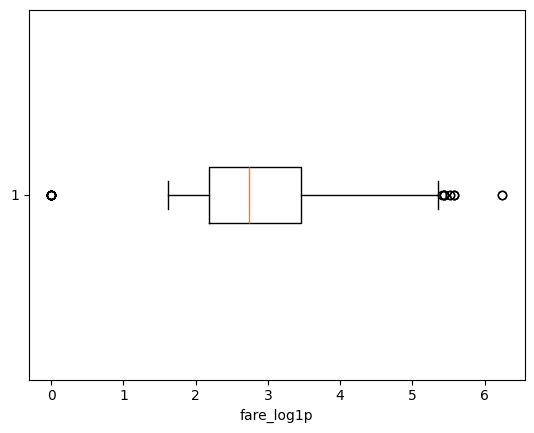

In [108]:
fig, ax = plt.subplots()
ax.boxplot(X_train['fare_log1p'], vert=False)
ax.set_xlabel('fare_log1p')
plt.show()

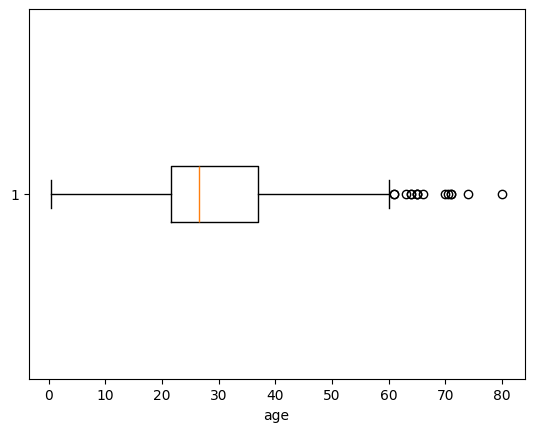

In [109]:
fig, ax = plt.subplots()
ax.boxplot(X_train['age'], vert=False)
ax.set_xlabel('age')
plt.show()

In [110]:
X_train[['fare_log1p', 'age']].describe()

,fare_log1p,age
count,710.000000,710.000000
mean,2.946735,29.331577
std,0.978001,13.244686
min,0.000000,0.420000
25%,2.185579,21.500000
50%,2.737881,26.500000
75%,3.456184,37.000000
max,6.240917,80.000000


In [111]:
# Quant-ish reasoning (tail checks) — formulas & numbers
#
# Definitions (compute on TRAIN only, per column):
#   Q1  = 25th percentile
#   Q3  = 75th percentile
#   IQR = Q3 - Q1
#   Right-tail index  = (Max - Q3) / IQR
#   Left-tail  index  = (Q1  - Min) / IQR
#
# Rule of thumb:
#   - If Right-tail index > ~5 (or Left-tail > ~5) → heavy tail/outliers → consider RobustScaler
#   - Else (≤ ~5) → StandardScaler is appropriate for distance/linear models
#   - Tree ensembles ignore scaling either way
#
# Apply to features (approx values):
#   log_fare:
#     Max ≈ 6.20, Q3 ≈ 3.46, Q1 ≈ 2.19  → IQR ≈ 1.27
#     Right-tail index  ≈ (6.20 - 3.46) / 1.27 ≈ 2.2   ← mild
#     Left-tail  index  ≈ (2.19 - 0.00) / 1.27 ≈ 1.7   ← mild
#     → Use StandardScaler (if using SVC/KNN/Linear models)
#
#   age:
#     Max ≈ 80.0, Q3 ≈ 37.0, Q1 ≈ 21.5   → IQR ≈ 15.5
#     Right-tail index  ≈ (80.0 - 37.0) / 15.5 ≈ 2.8   ← mild/moderate
#     Left-tail  index  ≈ (21.5 - 0.42) / 15.5 ≈ 1.4   ← mild
#     → Use StandardScaler (if using SVC/KNN/Linear models)
#
# Summary for your dataset:
#   - Tail indices are well below 5 → StandardScaler is the right default
#   - For tree ensembles: no scaling; use age (raw) and log_fare (as-is)


In [112]:
from sklearn.preprocessing import StandardScaler

cols = ['age', 'fare_log1p']

scaler = StandardScaler()

In [113]:
X_train_tree = X_train.copy()
X_test_tree = X_test.copy()

In [114]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [115]:
scaler.fit(X_train_scaled[cols])

X_train_scaled[cols] = scaler.transform(X_train_scaled[cols])
X_test_scaled[cols] = scaler.transform(X_test_scaled[cols])

In [116]:
X_train_scaled.sample()

,pclass,sex,age,fare_log1p,family_size,is_alone,cabin_known,embarked_C,embarked_Q,embarked_S
797,3,1,0.126058,-0.692033,1,1,1,0.0,0.0,1.0


In [117]:
X_test_scaled.sample()

,pclass,sex,age,fare_log1p,family_size,is_alone,cabin_known,embarked_C,embarked_Q,embarked_S
33,3,0,-0.327273,-0.807496,1,1,0,0.0,0.0,1.0


In [118]:
scaler.mean_, scaler.scale_


(array([29.33157746,  2.94673508]), array([13.23535555,  0.97731194]))

In [119]:
X_train_scaled.head()

,pclass,sex,age,fare_log1p,family_size,is_alone,cabin_known,embarked_C,embarked_Q,embarked_S
692,3,0,-0.251718,1.130629,1,1,1,0.0,0.0,1.0
481,2,0,0.050503,-3.015143,1,1,1,0.0,0.0,1.0
527,1,0,0.806055,2.516542,1,1,0,0.0,0.0,1.0
855,3,1,-0.856160,-0.623904,2,0,1,0.0,0.0,1.0
801,2,1,0.126058,0.366637,3,0,1,0.0,0.0,1.0


In [120]:
import os

os.makedirs('data/processed', exist_ok=True)

In [121]:
X_train_scaled.to_csv("data/processed/X_train_scaled.csv", index=True)
X_test_scaled.to_csv( "data/processed/X_test_scaled.csv",  index=True)
X_train_tree.to_csv(  "data/processed/X_train_tree.csv",   index=True)
X_test_tree.to_csv(   "data/processed/X_test_tree.csv",    index=True)

y_train.to_frame("target").to_csv("data/processed/y_train.csv", index=True)
y_test.to_frame("target").to_csv( "data/processed/y_test.csv",  index=True)

In [122]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 710 entries, 692 to 507
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pclass       710 non-null    int64  
 1   sex          710 non-null    int64  
 2   age          710 non-null    float64
 3   fare_log1p   710 non-null    float64
 4   family_size  710 non-null    int64  
 5   is_alone     710 non-null    int64  
 6   cabin_known  710 non-null    int64  
 7   embarked_C   710 non-null    float64
 8   embarked_Q   710 non-null    float64
 9   embarked_S   710 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 61.0 KB
